In [1]:
using CSV, Distributions, Extremes, DataFrames, Gadfly, Random

# Extrapolation pour des données presque exponentielles

Loi a queue légère.

## Generation de données presque exponentielles

- n : observations par année
- m : années d'observation
- T : période de retour

In [2]:
pd = Gamma(.95, 9.844875339608)

n = 300
m = 80

T = 100

100

In [3]:
# Calcul de la vraie valeur qui est dépassée en moyenne une fois au T ans.

α = 1/(n*T)
q = quantile(pd, 1-α)

100.00000000002315

## Extrapolation statistique de la valeur qui est dépassée en moyenne une fois au T ans.

Utilisation de trois méthodes pour l'extrapolation.

1. Ajustement de la loi exponentielle à toutes les données (petite erreur de modèle) et extrapolation.
2. Extraction des maxima annuels puis estimation de la loi GEV par maximum de la vraisemblance.
3. Extraction des maxima annuels puis estimation de la loi de Gumbel par maximum de la vraisemblance.

In [4]:
df = DataFrame(Exponential = Float64[], GEV = Float64[], Gumbel = Float64[])

for _ in 1:2000
    x = rand(pd, n, m)
    fm = fit(Exponential, x)
    q̂ = quantile(fm, 1-α)
    
    z = vec(maximum(x, dims=1))
    
    evm = fit(GeneralizedExtremeValue, z)
    r̂ = quantile(evm, 1-1/T)
    
    evm_gumbel = fit(Gumbel, z)
    r̂_pwm = quantile(evm_gumbel, 1-1/T)
    
    push!(df, [q̂, r̂, r̂_pwm])
end

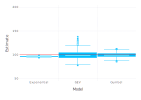

In [5]:
df2 = stack(df)
rename!(df2, :variable => :Model, :value => :Estimate)

plot(df2, yintercept=[q], Geom.hline(color="red"),
    x=:Model, y=:Estimate, Geom.boxplot,
    Coord.cartesian(ymin=50, ymax=200))

# Extrapolation pour des données presque normales

Loi a queue lourde.

## Generation de données presque normales

- n : observations par année
- m : années d'observation
- T : période de retour

In [6]:
pd = TDist(10)

n = 300
m = 80

T = 100

100

In [7]:
# Calcul de la vraie valeur qui est dépassée en moyenne une fois au T ans.

α = 1/(n*T)
q = quantile(pd, 1-α)

6.526644946392224

## Extrapolation statistique de la valeur qui est dépassée en moyenne une fois au T ans.

Utilisation de trois méthodes pour l'extrapolation.

1. Ajustement de la loi exponentielle à toutes les données (petite erreur de modèle) et extrapolation.
2. Extraction des maxima annuels puis estimation de la loi GEV par maximum de la vraisemblance.
3. Extraction des maxima annuels puis estimation de la loi de Gumbel par maximum de la vraisemblance.

In [8]:
df = DataFrame(Normal = Float64[], GEV = Float64[], Gumbel = Float64[])

for _ in 1:2000
    x = rand(pd, n, m)
    fm = fit(Normal, x)
    q̂ = quantile(fm, 1-α)
    
    z = vec(maximum(x, dims=1))
    
    evm = fit(GeneralizedExtremeValue, z)
    r̂ = quantile(evm, 1-1/T)
    
    evm_gumbel = fit(Gumbel, z)
    r̂_pwm = quantile(evm_gumbel, 1-1/T)
    
    push!(df, [q̂, r̂, r̂_pwm])
end

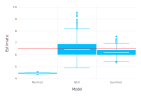

In [9]:
df2 = stack(df)
rename!(df2, :variable => :Model, :value => :Estimate)

plot(df2, yintercept=[q], Geom.hline(color="red"),
    x=:Model, y=:Estimate, Geom.boxplot)

# Extrapolation avec le meilleur modèle

In [10]:
pd = Gamma(.95, 9.844875339608)

n = 300
m = 80

T = 100

α = 1/(n*T)
q = quantile(pd, 1-α)

100.00000000002315

In [11]:
Random.seed!(12345)

x = rand(pd, n, m)
z = vec(maximum(x, dims=1));

In [12]:
df = DataFrame(Model = String[], BIC = Float64[], q̂ = Float64[])

models = [Normal, Gamma, LogNormal, GeneralizedExtremeValue]

for model in models

    fm = fit(model, z)
    
    q̂ = quantile(fm, 1-1/T)
    
    k = length(params(fm))
    
    bic = k*log(m) - 2*loglikelihood(fm, z)
    
    push!(df, [string(model) bic q̂])
    
end

sort!(df, :BIC)

Row,Model,BIC,q̂
,String,Float64,Float64
1,LogNormal,631.291,93.1803
2,Gamma,632.571,90.5813
3,GeneralizedExtremeValue,635.073,94.888
4,Normal,637.935,87.5256


## Reprise de ces étapes un grand nombre de fois

In [13]:
df2 = DataFrame(BestModel = Float64[], GEV = Float64[])

for _ in 1:5000

    df = DataFrame(Model = String[], BIC = Float64[], q̂ = Float64[])

    models = [Normal, Gamma, LogNormal, GeneralizedExtremeValue]
    
    x = rand(pd, n, m)
    z = vec(maximum(x, dims=1))

    for model in models

        fm = fit(model, z)

        q̂ = quantile(fm, 1-1/T)

        k = length(params(fm))

        bic = k*log(m) - 2*loglikelihood(fm, z)

        push!(df, [string(model) bic q̂])

    end

    sort!(df, :BIC)
    
    push!(df2, [ df.q̂[1] df[df.Model.=="GeneralizedExtremeValue",:q̂] ])
    
end

first(df2, 5)

Row,BestModel,GEV
,Float64,Float64
1,96.5051,96.8413
2,92.6262,92.6262
3,95.9618,95.9618
4,93.9564,100.659
5,109.773,109.773


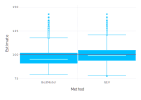

In [14]:
df3 = stack(df2, 1:2)
rename!(df3, :variable => :Method, :value => :Estimate)

plot(df3, yintercept=[q], Geom.hline(color="red"),
    x=:Method, y=:Estimate, Geom.boxplot)